In [48]:
import os
import json
from collections import defaultdict
from functools import reduce, partial
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [50]:
warnings.filterwarnings("ignore")

In [16]:
mutspec_dir = "../data/raw/birds/"
mutspec_lst = []
for path in os.listdir(mutspec_dir):
    m = pd.read_csv(mutspec_dir + path)
    m.rename({"RawMutSpec": path.strip(".csv")}, axis=1, inplace=True)
    mutspec_lst.append(m)

In [17]:
mutspec = reduce(partial(pd.merge, on="NucSubst"), mutspec_lst)

In [18]:
mutspec.to_csv("../data/raw/birds192.csv", index=None)

**Check**

In [34]:
overal_mutspec = mutspec.melt("NucSubst", var_name="Node", value_name="MutSpec")
overal_mutspec.head()

,NucSubst,Node,MutSpec
0,CAG>CCG,Node202,0.029412
1,TAA>TCA,Node202,0.028571
2,TAC>TCC,Node202,0.029412
3,CAA>CCA,Node202,0.021429
4,TCC>TAC,Node202,0.013889


In [52]:
a = mutspec[["NucSubst"]]
a["Mut"] = a.NucSubst.str.get(1) + '>' + a.NucSubst.str.get(-2)
a["Context"] = a.NucSubst.str.slice(0, 3)
a = a.sort_values(["Mut", "Context"])
a.head()

,NucSubst,Mut,Context
70,AAA>ACA,A>C,AAA
173,AAC>ACC,A>C,AAC
28,AAG>ACG,A>C,AAG
174,AAT>ACT,A>C,AAT
3,CAA>CCA,A>C,CAA


<AxesSubplot:xlabel='NucSubst', ylabel='MutSpec'>

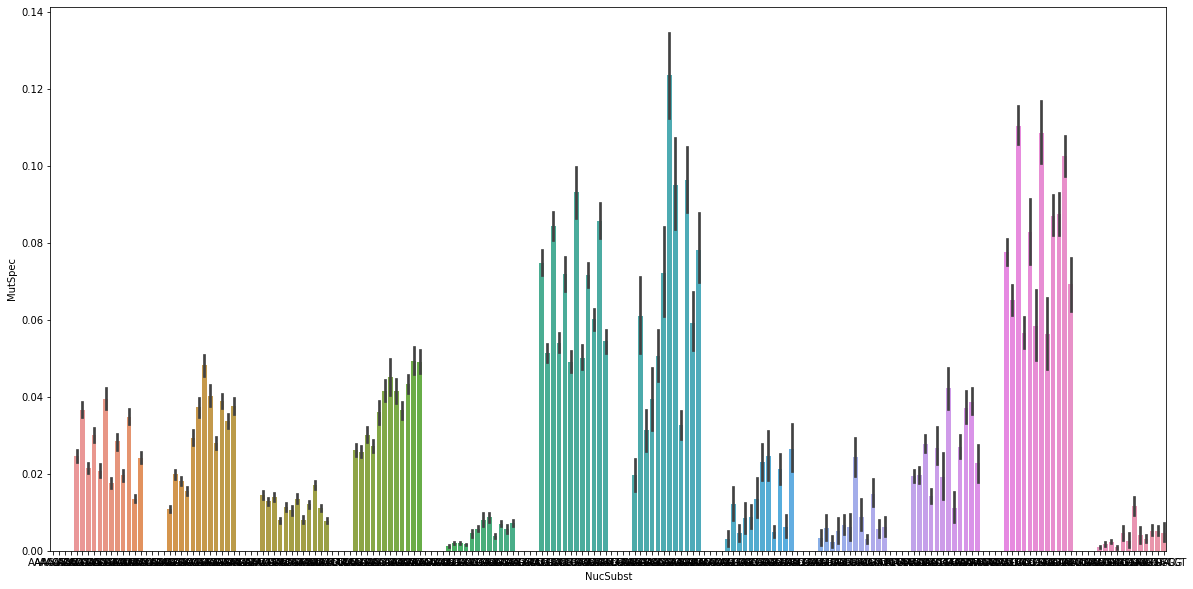

In [54]:
plt.figure(figsize=(20, 10))
sns.barplot(data=overal_mutspec, x="NucSubst", y="MutSpec", order=a.NucSubst.values)

In [62]:
mutspec.NucSubst.str.contains("^\w{3}>\w{3}$").sum() == 192

True

In [2]:
PATH_TO_HUMAN_COUNTS = "../data/codon_counts_GRCh37.json"
PATH_TO_SIGNATURES = "../data/external/COSMIC_v3.2_SBS_GRCh37.txt"
PATH_TO_SIGNATURES_NORMALIZED = "../data/COSMIC_v3.2_SBS_GRCh37_normalized.txt"
PATH_TO_MUTSPEC = "../../birds/data/processed/mutspec96.tsv"

In [3]:
translator = str.maketrans("ATGC", "TACG")


In [4]:
def load_triplet_counts(path: str, normalize=False) -> pd.Series:
    """ read and collapse raw trinucleotide counts """
    considerable_nucs = {"C", "T"}
    with open(path) as fin:
        counts = json.load(fin)

    new_counts = defaultdict(int)
    for trinuc, num in counts.items():
        standart_trinuc = trinuc.upper()
        if len(set(standart_trinuc).difference("ATGC")) == 0:
            if standart_trinuc[1] not in considerable_nucs:
                standart_trinuc = standart_trinuc.translate(translator)
            new_counts[standart_trinuc] += num
            
    new_counts = pd.Series(new_counts)
    if normalize:
        new_counts = new_counts / new_counts.median()
    return new_counts.sort_index()

In [5]:
human_triplet_counts = load_triplet_counts(PATH_TO_HUMAN_COUNTS, True)
signatures = pd.read_csv(PATH_TO_SIGNATURES, sep="\t", index_col=0)
signatures_norm = pd.read_csv(PATH_TO_SIGNATURES_NORMALIZED, sep="\t", index_col=0)
mutspec = pd.read_csv(PATH_TO_MUTSPEC, sep="\t")

In [6]:
mutspec.head()

,Mutation Types,Acanthisitta_ch,Acanthorhynchus,Accipiter_genti,Accipiter_nisus,Accipiter_trivi,Accipiter_virga,Aceros_waldeni,Acridotheres_cr,Acridotheres_tr,...,Xiphorhynchus_e,Yuhina_diademat,Yuhina_nigrimen,Zenaida_auricul,Zenaida_macrour,Zonotrichia_alb,Zosterops_abyss,Zosterops_eryth,Zosterops_later,Zosterops_polio
0,A[C>A]A,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.076923,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
1,A[C>A]C,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
2,A[C>A]G,0.0,0.000000,0.285714,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.2,0.111111,0.0,0.0,0.0,0.076923,0.0,0.0
3,A[C>A]T,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.090909,0.0,0.0
4,A[C>G]A,0.0,0.285714,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0


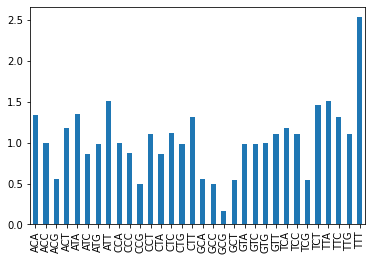

In [8]:
human_triplet_counts.plot.bar();

In [9]:
mutspec["Context"] = mutspec["Mutation Types"].str.extract(
    "(\w)\[(\w)>\w\](\w)").apply(lambda x: "".join(x), axis=1)

In [10]:
mutspec.head()

,Mutation Types,Acanthisitta_ch,Acanthorhynchus,Accipiter_genti,Accipiter_nisus,Accipiter_trivi,Accipiter_virga,Aceros_waldeni,Acridotheres_cr,Acridotheres_tr,...,Yuhina_diademat,Yuhina_nigrimen,Zenaida_auricul,Zenaida_macrour,Zonotrichia_alb,Zosterops_abyss,Zosterops_eryth,Zosterops_later,Zosterops_polio,Context
0,A[C>A]A,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.076923,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,ACA
1,A[C>A]C,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,ACC
2,A[C>A]G,0.0,0.000000,0.285714,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.2,0.111111,0.0,0.0,0.0,0.076923,0.0,0.0,ACG
3,A[C>A]T,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.090909,0.0,0.0,ACT
4,A[C>G]A,0.0,0.285714,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,ACA


In [11]:
triplet_freqs = human_triplet_counts.reset_index(name="Freq").rename({"index": "Context"}, axis=1)

In [21]:
ext_mutspec = pd.merge(mutspec, triplet_freqs, on="Context").sort_values("Mutation Types")
ext_mutspec.head()

,Mutation Types,Acanthisitta_ch,Acanthorhynchus,Accipiter_genti,Accipiter_nisus,Accipiter_trivi,Accipiter_virga,Aceros_waldeni,Acridotheres_cr,Acridotheres_tr,...,Yuhina_nigrimen,Zenaida_auricul,Zenaida_macrour,Zonotrichia_alb,Zosterops_abyss,Zosterops_eryth,Zosterops_later,Zosterops_polio,Context,Freq
0,A[C>A]A,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.076923,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,ACA,1.334506
3,A[C>A]C,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,ACC,1.000506
6,A[C>A]G,0.0,0.000000,0.285714,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.2,0.111111,0.0,0.0,0.0,0.076923,0.0,0.0,ACG,0.561735
9,A[C>A]T,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.090909,0.0,0.0,ACT,1.180098
1,A[C>G]A,0.0,0.285714,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,ACA,1.334506


In [46]:
additional_cols = {"Context", "Freq", "Mutation Types"}
for c in ext_mutspec.columns:
    if c in additional_cols or ext_mutspec[c].max() <= 0:
        continue
    new_mutspec = ext_mutspec[c] * ext_mutspec["Freq"]  #.astype(int)
    mina = new_mutspec[new_mutspec > 0].min()
    new_mutspec = new_mutspec / mina
    ext_mutspec[c] = np.round(new_mutspec).astype(int)
ext_mutspec.drop(["Context", "Freq"], axis=1, inplace=True)

In [48]:
ext_mutspec.to_csv(PATH_TO_MUTSPEC.replace(".tsv", "_norm_to_human.tsv"), sep="\t", index=None)